## ASTR496: Foundations of Data Science in Astronomy
Gautham Narayan
gsn@illinois.edu

### Midterm

In [30]:
# Q1: Maximum Likelihood Estimation for Stellar Parameters
# Estimating Temperature and Extinction from Multi-band Photometry

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

#### **Problem Setup:**
#### - We observe a star in multiple photometric bands (B, V, R, I, J, H, K)
#### - We want to estimate: stellar temperature T and visual extinction A_V
#### - We assume we know the distance from e.g. Gaia (or fit for it separately)
####
#### **Model:**
#### For each filter λ, the observed magnitude is:
####
#### m_λ = M_λ(T) + 5*log₁₀(d/10) + A_V * R_λ
####
#### where:
#### - M_λ(T) = absolute magnitude in filter λ for temperature T
#### - d = distance in parsecs
#### - A_V = visual extinction
#### - R_λ = extinction coefficient for filter λ

### First, I have to give you a stellar model as a function of wavelength
### We'll use a Planck function i.e. a blackbody

In [31]:
def planck_function(wavelength, temperature):
    """
    Planck function for blackbody radiation
    wavelength in microns, temperature in Kelvin
    Returns relative flux (arbitrary units)
    """
    h = 6.626e-34  # Planck constant
    c = 3e8        # Speed of light
    k = 1.381e-23  # Boltzmann constant

    wl_m = wavelength * 1e-6  # Convert to meters

    # Planck function
    numerator = 2 * h * c**2
    denominator = wl_m**5 * (np.exp(h * c / (wl_m * k * temperature)) - 1)

    return numerator / denominator

### Next we need to define a photometric system - we'll use the Johnson(-Morgan) Kron-Cousins UBVRI filters and the reddening coefficients 
### and JHK for the IR, largely because you can look up the filter's effective wavelengths $\lambda_\text{eff}$ in microns and the reddening coefficients from something like Cardelli-Clayton-Mathis '89.

In [32]:
filters = {
    'B': {'lambda_eff': 0.44, 'R_lambda': 4.1},   # Blue
    'V': {'lambda_eff': 0.55, 'R_lambda': 3.1},   # Visual (reference)
    'R': {'lambda_eff': 0.64, 'R_lambda': 2.7},   # Red
    'I': {'lambda_eff': 0.79, 'R_lambda': 2.0},   # Near-IR
    'J': {'lambda_eff': 1.25, 'R_lambda': 0.9},   # IR
    'H': {'lambda_eff': 1.63, 'R_lambda': 0.6},   # IR
    'K': {'lambda_eff': 2.19, 'R_lambda': 0.4}    # IR
}

In [33]:
# here are some quick arrays of the filters, wavelengths and reddening coefficients.
filter_names = list(filters.keys())
wavelengths = np.array([filters[f]['lambda_eff'] for f in filter_names])
R_lambda = np.array([filters[f]['R_lambda'] for f in filter_names])

print(f"Photometric filters: {filter_names}")
print(f"Effective wavelengths (μm): {wavelengths}")
print(f"Extinction coefficients R_λ: {R_lambda}")

Photometric filters: ['B', 'V', 'R', 'I', 'J', 'H', 'K']
Effective wavelengths (μm): [0.44 0.55 0.64 0.79 1.25 1.63 2.19]
Extinction coefficients R_λ: [4.1 3.1 2.7 2.  0.9 0.6 0.4]


### Next, we need to reate the magnitudes of a star, given the spectral model 
### While we are using the Planck function as an approximation, we'll tie the fluxes to the obsserved flux of the 
### Sun itself, with $T_{\text{eff}} = 5778$ K, and $M_V = 4.83$ (remember the absolute magnitude is defined for a distance of 10pc).

In [65]:
# Create stellar atmosphere model
def stellar_magnitude(temperature, filter_name, reference_temp=5778):
    """
    Calculate absolute magnitude for a star of given temperature
    Simplified model based on Planck function + calibration
    """
    wl = filters[filter_name]['lambda_eff']

    # Get flux ratio compared to solar temperature
    flux_star = planck_function(wl, temperature)
    flux_sun = planck_function(wl, reference_temp)
    flux_ratio = flux_star / flux_sun

    # Convert to magnitude difference (Sun has M_V = 4.83)
    # Add wavelength-dependent correction for more realism
    solar_magnitude = 4.83 + 0.5 * (wl - 0.55)  # Rough color correction

    magnitude = solar_magnitude - 2.5 * np.log10(flux_ratio)

    return magnitude

### Q1. As a function of temperature (3000-10,000K in 1000K steps) determine the B-V color

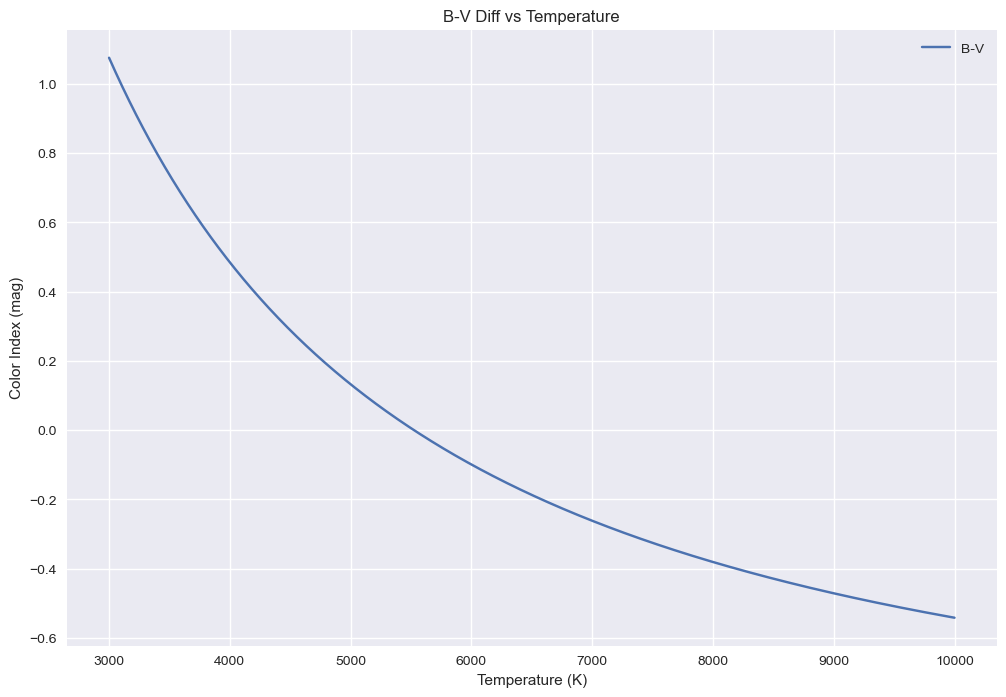

In [73]:
### YOUR ANSWER HERE
def magnitude_diff(temperature, magnitude = ['B', 'V']):
    """
    Calculate B-V color index for a star of given temperature
    """
    if len(magnitude) != 2:
        raise ValueError("magnitude list must contain exactly two filter names.")
    
    M_0 = stellar_magnitude(temperature, magnitude[0])
    M_1 = stellar_magnitude(temperature, magnitude[1])
    return M_0 - M_1
temp = np.linspace(3000, 10000, 1000)

plt.plot(temp, magnitude_diff(temp, ['B', 'V']), label = 'B-V')

plt.xlabel('Temperature (K)')
plt.ylabel('Color Index (mag)')
plt.title('B-V Diff vs Temperature')
plt.legend()

plt.show()

### Next, I'll give you the "Truth" and some synthetic stellar data, with the true magnitudes of this star in each band using my `stellar_magnitude` but with the reddening and distance correction applied (you're going to have to do this)

In [36]:
# Generate a test star
TRUE_TEMP = 6500  # K
TRUE_A_V = 0.8    # magnitudes
TRUE_DISTANCE = 100    # parsecs


synthetic_star =  {'B': {'magnitude': 12.379, 'error': 0.02, 'true_magnitude': 12.369},
                   'V': {'magnitude': 11.752, 'error': 0.03, 'true_magnitude': 11.756},
                   'R': {'magnitude': 11.579, 'error': 0.04, 'true_magnitude': 11.553},
                   'I': {'magnitude': 11.225, 'error': 0.05, 'true_magnitude': 11.149},
                   'J': {'magnitude': 10.602, 'error': 0.06, 'true_magnitude': 10.616},
                   'H': {'magnitude': 10.592, 'error': 0.07, 'true_magnitude': 10.609},
                   'K': {'magnitude': 10.888, 'error': 0.08, 'true_magnitude': 10.762}}

syn_filter_names = list(synthetic_star.keys())
synthetic_star['B']['true_magnitude'] - synthetic_star['V']['true_magnitude']

0.6129999999999995

### Q2.  
### OK, you know the drill 
### define a function that gives you the model magnitudes of the star given the temperature, extinction and distance
### define the log-likelihood
### Use `scipy.optimize` to get the best fit parameters for this star using maximum likelihood estimation
### Calculate the goodness of fit i.e. reduced chi-squared
### Calculate the Inverse Hessian Matrix and report the simple uncertainties on each parameter
### Which parameters are correlated strongly?

In [ ]:
### YOUR ANSWER HERE
def magnitude_model(temperature, A_V, distance):
    """
    Model magnitudes for a star given temperature, extinction A_V, and distance
    """
    model_magnitudes = {}
    for f in filter_names:
        M = stellar_magnitude(temperature, f)
        R_lambda = A_V * filters[f]['R_lambda'] / filters['V']['R_lambda']
        m = M + 5 * np.log10(distance/10) + A_V * R_lambda
        model_magnitudes[f] = m
    return model_magnitudes

In [ ]:
def log_likelihood(theta, x, y, y_err):
    """
    Calculate the log-likelihood of the model given the data.
    theta : array
        Model parameters [temperature, A_V, distance]
    x : array
        Observations
    y : array
        Observed Data
    y_err : float
        Measurement uncertainty
    """
    temperature, A_V, distance = theta
    model_magnitudes = magnitude_model(temperature, A_V, distance)

    model = np.array([model_magnitudes[f] for f in x], dtype=float)
    
    sigma2 = y_err ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))


In [ ]:
# Maximum likelihood estimation with scipy.optimize
# Initial guess (Given)
initial_guess = [5500, 0.5, 75]  # Temperature, A_V, Distance

# Prep Data
observed_mags = np.array([synthetic_star[f]['magnitude'] for f in syn_filter_names], dtype=float) # Synthetic observed magnitudes
observed_errors = np.array([synthetic_star[f]['error'] for f in syn_filter_names], dtype=float) # Synthetic observed errors

def neg_log_likelihood(theta, filters, mags, errors):
    return -log_likelihood(theta, filters, mags, errors)

result = minimize(
    neg_log_likelihood,
    initial_guess,
    args=(syn_filter_names, observed_mags, observed_errors),
    method='Nelder-Mead',
    options={'xatol': 1e-6, 'fatol': 1e-6, 'maxiter': 2000}
)
best_temperature, best_A_V, best_distance = result.x
best_log_like = log_likelihood(result.x, syn_filter_names, observed_mags, observed_errors)

print(f'Optimization successful: {result.success}')
print(f'Best-fit temperature: {best_temperature:.2f} K')
print(f'Best-fit A_V: {best_A_V:.3f} mag')
print(f'Best-fit distance: {best_distance:.2f} pc')
print(f'Maximum log-likelihood: {best_log_like:.3f}')


Optimization successful: True
Best-fit temperature: 7639.94 K
Best-fit A_V: 1.709 mag
Best-fit distance: 111.84 pc
Maximum log-likelihood: 13.545


### Q3.

### It is worth remembering the difference between Monte Carlo and Markov Chain Monte Carlo
### Using the same true parameters provided to you with Q2, generate 1000 random stars with the same true values, but different random seeds
### Repeat your analysis in Q2 for each of these 1000 stars, saving the results
### Use the results from this Monte Carlo process to determine a more robust uncertainty estimate, and measure the mean bias (i.e. how far are you from the truth) in parameter recovery

In [40]:
### YOUR ANSWER HERE

### Q4. 

### Finally, try this problem with a Markov Chain Monte Carlo but this time, incorporating a prior on the distance of 98 +/- 5 pc from synthetic Gaia, but repeating the anaysis three times - once with all filters, next with RIJHK and then with BVRIJ only.

#### Make reasonable choices for the number of walkers, steps, thinning etc. It's your responsibility to ensure the posteriors are well sampled.

### Show corner plots for all three cases in the same figure (you can try the `ChainConsumer` package)

### How do these results compare, and what happens to the extinction and temperature with fewer bands, and in the case of all filters, with your answer from Q2/Q3. 

In [41]:
### YOUR ANSWER HERE